## This notebook provide the instructions on how to read UBC firesmoke data from the cloud using OpenVisus framework.

### To run this notebook properly, you need to install the library `OpenVisus`. To install this, please run the following command from your terminal:
`pip install OpenVisus`

Dashboard visible here: http://chpc3.nationalsciencedatafabric.org:9988/dashboards

# **Step 1: Importing the libraries**

### Please be sure to have libraries installed

In [13]:
# for numerical work
import numpy as np

# for accessing file system
import os

# for loading netcdf files, for metadata
import xarray as xr

# openvisus opens the .idx file
# https://github.com/sci-visus/OpenVisus/tree/master
os.environ["VISUS_CACHE"]="./visus_cache_can_be_erased"
from OpenVisus import *

# for general plotting
import matplotlib.pyplot as plt

# for processing time data as datetime objects, if desired
import datetime
import time
start_time = time.time()

### Here we set a variable to the location of our data

In [14]:
pm25 = "http://atlantis.sci.utah.edu/mod_visus?dataset=UBC_fire_smoke_BSC00CA12-01&cached=arco"

In [15]:
!python --version

Python 3.9.18


## **Step 2: Reading the metadata file from cloud**
### In this section, we load our data using `LoadDataset`. We are just reading the metadata for the dataset here.

In [16]:
db=LoadDataset(pm25)
print(f'Dimensions: {db.getLogicBox()[1][0]}*{db.getLogicBox()[1][1]}')
longitude_levels = db.getLogicBox()[1][0]
latitude_levels = db.getLogicBox()[1][1]

print(f'Total Timesteps: {len(db.getTimesteps())}')
print(f'Field: {db.getField().name}')
print('Data Type: float32')

Dimensions: 1081*381
Total Timesteps: 24817
Field: PM25
Data Type: float32


## For now we will manually load metadata from separate files

### Load latitude and longitude grid

In [17]:
# Load the netcdf file with BSC00CA12-01's lat, lon, and time metadata
ds = xr.open_dataset("BSC00CA12-01-metadata.netcdf")

# Get metadata to compute lon and lat
xorig = ds.XORIG
yorig = ds.YORIG
xcell = ds.XCELL
ycell = ds.YCELL
ncols = ds.NCOLS
nrows = ds.NROWS

longitude = np.linspace(xorig, xorig + xcell * (ncols - 1), ncols)
latitude = np.linspace(yorig, yorig + ycell * (nrows - 1), nrows)

In [18]:
longitude

array([-160.        , -159.9       , -159.8       , ...,  -52.19999839,
        -52.09999839,  -51.99999839])

In [19]:
np.size(longitude)

1081

In [20]:
np.size(latitude)

381

### Get date and time data

In [9]:
# Load the numpy array that contains the date data of format "YYYYMMDD HH:HH:HH"
timestamps = np.load("BSC00CA12-01-dates.npy")
np.size(timestamps)

24816

## **Step 3:  Data Selection**
This section shows you how to load the data you want. You can select any timestep you want. You can set the quality or resolution of the data as well. Higher quality means finer(more) data. 

Not setting any time means the first timestep available is selected. 

Not setting quality means full data resolution is selected which takes a while to load because of the higher filesize. 

In [10]:
timestamps[0]

'20210305 00:00:00'

In [12]:
# here you can select the resoution at which you query the data: -15 is very coarse, 0 is full resoltuon (dangerous since you may fetch a lot of data and wait a long time).
timestep = 0
data_resolution = 0 # try values among -15, -12, -9, -6, -3, 0

data2D=db.read(time=0,quality=data_resolution)
print(data2D.shape)
print(np.min(data2D),np.max(data2D))
print(timestamps[timestep])

(381, 1081)
0.0 2127.124


NameError: name 'timestamps' is not defined

In [12]:
data2D[0,0]

0.0

In [13]:
print(latitude[0], longitude[0])

32.0 -160.0


## **Step 4:  Visualize the data**
We are using a simple matplotlib here, but since the data is in numpy array, it can loaded with any python modules that support numpy. Feel free to set the `vmin`,`vmax` appropriately.

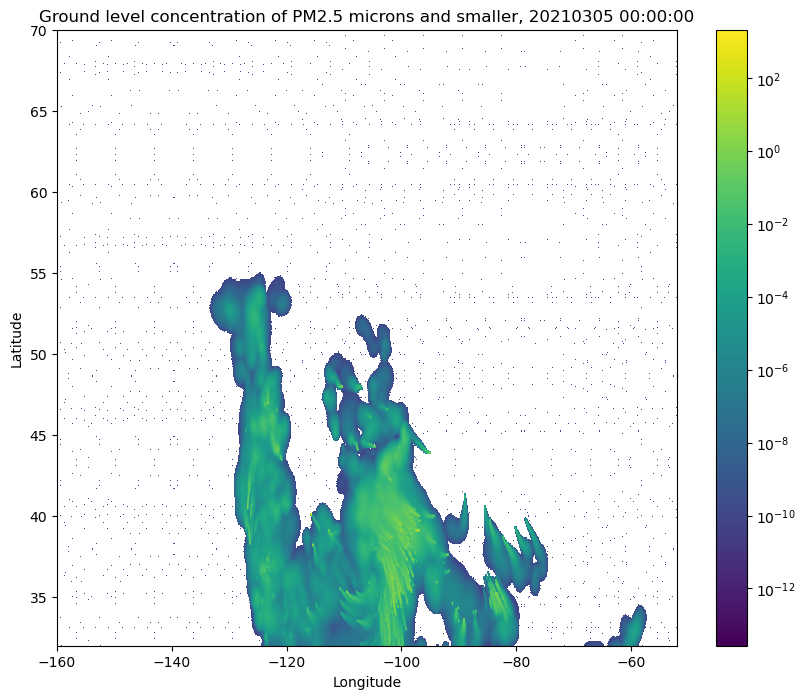

In [14]:
timestep = 0  #between 0 and 24817
data_resolution = 0 # try values among -15, -12, -9, -6, -3, 0

data_at_timestep = db.read(time=timestep, quality=data_resolution)
fig,axes=plt.subplots(1,1,figsize=(10,8))
axp = axes.imshow(data_at_timestep, extent=[np.min(longitude), np.max(longitude), np.min(latitude), np.max(latitude)], 
                  aspect='auto',origin='lower',cmap='viridis', norm='log')
plt.colorbar(axp,location='right')

# Set x and y axis labels
axes.set_xlabel('Longitude')
axes.set_ylabel('Latitude')

plt.title(f'Ground level concentration of PM2.5 microns and smaller, {timestamps[timestep]}')

plt.show()

## Perhaps you want to find the first day where the PM25 levels are above healthy standards for human health over 24 hours

ref: https://ww2.arb.ca.gov/resources/inhalable-particulate-matter-and-health

In [15]:
# Select a threshold, 35 µg/m3
threshold = 35

# # An array to hold the slices of data that meet the threshold
# data_of_interest = np.empty([24, data2D.shape[0], data2D.shape[1]])

# An array to hold the slices of data that meet the threshold
data_of_interest = []

# Counter to keep track of consecutive timesteps
consecutive_count = 0

# To track last timestep of consecutive hours
last_tstep = 0

# For all timesteps, append
for tstep in range(len(db.getTimesteps())):
    # Read in PM25 data at current timestep
    curr_data=db.read(time=tstep,quality=data_resolution)
    # If this slice has at least one PM25 value > our threshold , append to our data_of_interest
    if np.max(curr_data) > threshold:
        # If any value in the slice exceeds the threshold
        if np.max(curr_data) > threshold:
            # Increment consecutive count
            consecutive_count += 1
    
            # If we've reached 24 consecutive timesteps, break the loop
            if consecutive_count == 24:
                last_tstep=tstep
                break
        else:
            # Reset consecutive count if condition is not met
            consecutive_count = 0

# If 24 consecutive timesteps were found, append them to data_of_interest
if consecutive_count == 24:
    for tstep in range(last_tstep - 23, last_tstep + 1):
        curr_data = db.read(time=tstep, quality=data_resolution)
        data_of_interest.append(curr_data)
    
    # Convert the list of slices to a numpy array
    data_of_interest = np.array(data_of_interest)

Let's visualize the first hour of this data

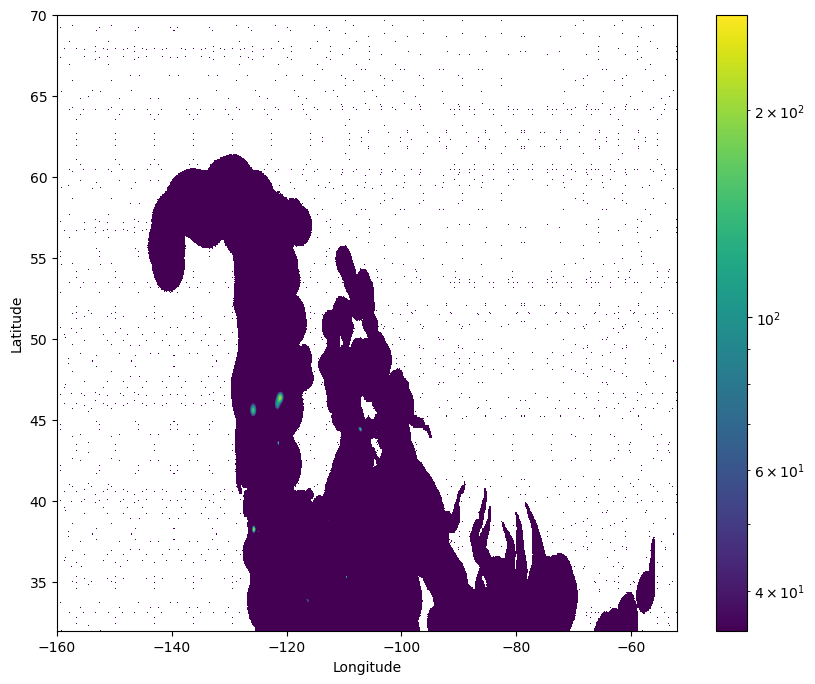

In [16]:
fig,axes=plt.subplots(1,1,figsize=(10,8))
axp = axes.imshow(data_of_interest[11], extent=[np.min(longitude), np.max(longitude), np.min(latitude), np.max(latitude)], 
                  aspect='auto',origin='lower',vmin=threshold,cmap='viridis', norm='log')
plt.colorbar(axp,location='right')

# Set x and y axis labels
axes.set_xlabel('Longitude')
axes.set_ylabel('Latitude')

plt.show()

### *Please reach out to Arleth Salinas or Valerio Pascucci for any concerns about the notebook. Thank you!*
- Arleth Salinas (arleth.salinas@utah.edu)
- Valerio Pascucci (pascucci.valerio@gmail.com)